# LAB 1

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

In [103]:
# Załadowanie daych
path = 'archive/'
all_files = glob.glob(os.path.join(path, "data-*"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t', header=None, names=['Date', 'Time', 'Code', 'Value'])

    df['Patient_ID'] = os.path.basename(filename)
    li.append(df)

full_data = pd.concat(li, axis=0, ignore_index=True)

In [104]:
# Przygotowanie danych
full_data['Timestamp'] = pd.to_datetime(full_data['Date'] + ' ' + full_data['Time'], errors='coerce')

full_data['Value'] = pd.to_numeric(full_data['Value'], errors='coerce')
full_data.dropna(subset=['Timestamp', 'Value'], inplace=True)
full_data.sort_values(by=['Patient_ID', 'Timestamp'], inplace=True)

# Mapowanie i grupowanie kodów
intensity_map = {
    68: 1, 66: 2, 67: 3,  # Posiłki: mały, typowy, duży
    71: 1, 69: 2, 70: 3   # Ćwiczenia: małe, typowe, duże
}
def group_codes(code):
    if code in [33, 34, 35]: return 'Insulin_Dose'
    if code in [48, 57, 58, 59, 60, 61, 62, 63, 64]: return 'Glucose_Level'
    if code in [66, 67, 68]: return 'Meal_Intensity'
    if code in [69, 70, 71]: return 'Exercise'
    if code == 65: return 'Hypoglycemic_Symptoms'
    return 'Other'

full_data['Category'] = full_data['Code'].apply(group_codes)
# full_data['Model_Value'] = full_data.apply(lambda row: intensity_map.get(row['Code'], row['Value']), axis=1)
full_data['Model_Value'] = full_data.apply(lambda row: 1 if row['Code'] == 65 else intensity_map.get(row['Code'], row['Value']), axis=1)
# Wyciągnięcie cech czasowych
full_data['Hour'] = full_data['Timestamp'].dt.hour
full_data['Time_Delta'] = full_data.groupby('Patient_ID')['Timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())

# Pivotowanie
df_model = full_data.pivot_table(
    index=['Patient_ID', 'Timestamp', 'Hour', 'Time_Delta'],
    columns='Category',
    values='Model_Value',
    aggfunc='mean'
).reset_index()

# Uzupełniamy dane w czasie

cols_to_fill = ['Glucose_Level', 'Insulin_Dose', 'Meal_Intensity', 'Exercise', 'Hypoglycemic_Symptoms', 'Other']
for col in cols_to_fill:
    if col in df_model.columns:
        df_model[col] = df_model.groupby('Patient_ID')[col].ffill().fillna(0)
#print("Finalne kolumny gotowe do modelu:", df_model.columns.tolist())


# Sprawdzenie hypoglycemic symptoms
# print(f"Suma objawów: {df_model['Hypoglycemic_Symptoms'].sum()}")
# print(full_data[full_data['Code'] == 65])
print("Liczba odnotowanych objawów hipoglikemii:", df_model['Hypoglycemic_Symptoms'].sum())
print(df_model.describe())
# df_model

Liczba odnotowanych objawów hipoglikemii: 7988.0
Category                   Timestamp          Hour    Time_Delta  \
count                          18319  18319.000000  1.831900e+04   
mean      1990-09-03 10:57:06.530924     14.036083  3.747155e+06   
min              1988-03-27 08:00:00      0.000000  0.000000e+00   
25%              1990-05-18 21:15:00      8.000000  1.035960e+06   
50%              1990-09-20 11:52:00     14.000000  2.144820e+06   
75%              1991-05-08 01:47:30     18.000000  4.847370e+06   
max              1991-09-23 21:10:00     23.000000  2.484720e+07   
std                              NaN      5.851555  4.266264e+06   

Category      Exercise  Glucose_Level  Hypoglycemic_Symptoms  Insulin_Dose  \
count     18319.000000   18319.000000           18319.000000  18319.000000   
mean          0.662809     162.159288               0.436050      8.304038   
min           0.000000       0.000000               0.000000      0.000000   
25%           0.000000    

Regresja Liniowa

In [97]:
# 1. Przygotowanie danych
df_model.drop(columns=['Timestamp', 'Patient_ID', 'Other'], inplace=True)

X = df_model.drop(columns=['Glucose_Level'])
y = df_model['Glucose_Level']

# 2. Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Budowa i trenowanie modelu
model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)

# 5. Przewidywanie i wyniki
y_pred = model_reg.predict(X_test_scaled)

print(f"Błąd MAE: {mean_absolute_error(y_test, y_pred):.2f} mg/dL")
print(f"Wynik R2: {r2_score(y_test, y_pred):.4f}")

Błąd MAE: 66.53 mg/dL
Wynik R2: 0.0360


Wizualizacja

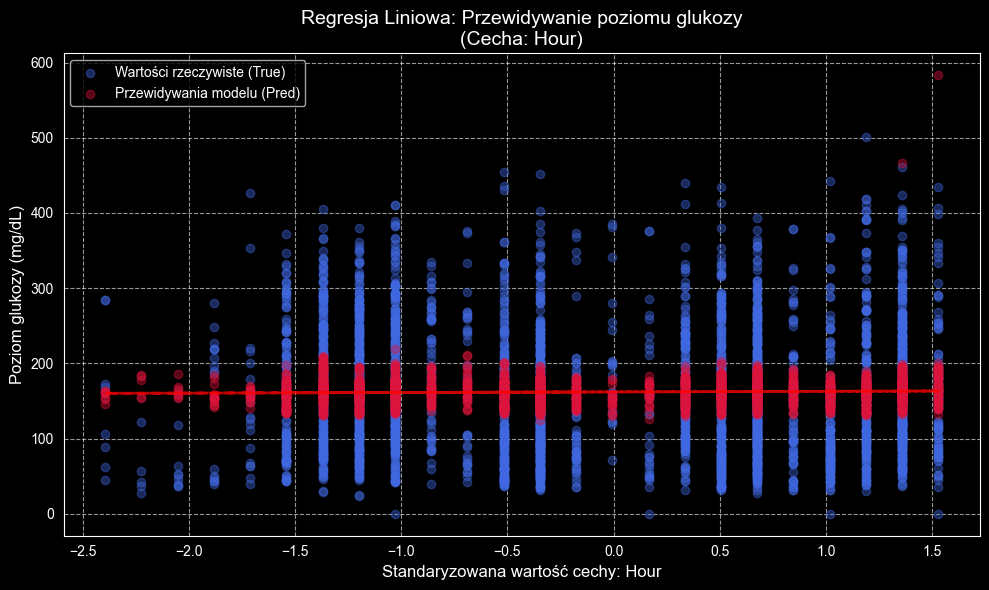

In [90]:
# 1. Obliczamy przewidywania dla modelu regresji liniowej
y_pred_lin = model_reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
feature_name = X.columns[0]

plt.scatter(X_test_scaled[:, 0], y_test, alpha=0.4, color='royalblue', label='Wartości rzeczywiste (True)')
plt.scatter(X_test_scaled[:, 0], y_pred_lin, alpha=0.4, color='crimson', label='Przewidywania modelu (Pred)')
z = np.polyfit(X_test_scaled[:, 0], y_pred_lin, 1)
p = np.poly1d(z)
plt.plot(X_test_scaled[:, 0], p(X_test_scaled[:, 0]), "r--", alpha=0.8, linewidth=2)

plt.title(f'Regresja Liniowa: Przewidywanie poziomu glukozy\n(Cecha: {feature_name})', fontsize=14)
plt.xlabel(f'Standaryzowana wartość cechy: {feature_name}', fontsize=12)
plt.ylabel('Poziom glukozy (mg/dL)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

SVM

In [76]:
# Tworzymy nową zmienną celu: 1 jeśli cukier > 180 (wysoki), 0 w przeciwnym razie
y_class = (df_model['Glucose_Level'] > 180).astype(int)

# Sprawdźmy, jak rozkładają się klasy
print(y_class.value_counts())

# 1. Podział danych
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 2. Skalowanie
scaler_svm = StandardScaler()
X_train_scaled_svm = scaler_svm.fit_transform(X_train_svm)
X_test_scaled_svm = scaler_svm.transform(X_test_svm)

# 3. Budowa i trenowanie modelu
# model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
model_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
model_svm.fit(X_train_scaled_svm, y_train_svm)

# 4. Predykcja
y_pred_svm = model_svm.predict(X_test_scaled_svm)

# 5. Ocena
print("\nRaport klasyfikacji:")
print(classification_report(y_test_svm, y_pred_svm))

Glucose_Level
0    11363
1     6956
Name: count, dtype: int64

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      2297
           1       0.46      0.63      0.53      1367

    accuracy                           0.59      3664
   macro avg       0.59      0.60      0.58      3664
weighted avg       0.62      0.59      0.60      3664



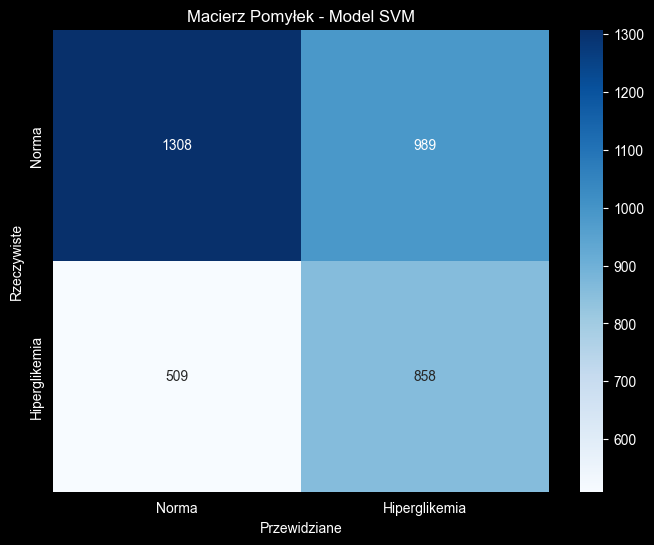

In [77]:
# Generowanie macierzy pomyłek
cm = confusion_matrix(y_test_svm, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Norma', 'Hiperglikemia'],
            yticklabels=['Norma', 'Hiperglikemia'])
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek - Model SVM')
plt.show()

Próba poprawy pracy modelu

In [106]:
# 3. Dodajemy Lagi i Średnie
df_model['Insulin_Lag1'] = df_model.groupby('Patient_ID')['Insulin_Dose'].shift(1).fillna(0)
df_model['Meal_Lag1'] = df_model.groupby('Patient_ID')['Meal_Intensity'].shift(1).fillna(0)
df_model['Glucose_Rolling_Mean'] = df_model.groupby('Patient_ID')['Glucose_Level'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# 4. Dodajemy fazy dnia i One-Hot Encoding
def get_day_phase(hour):
    if 6 <= hour < 10: return 'Morning'
    elif 10 <= hour < 18: return 'Day'
    elif 18 <= hour < 23: return 'Evening'
    else: return 'Night'

df_model['Day_Phase'] = df_model['Hour'].apply(get_day_phase)
df_model = pd.get_dummies(df_model, columns=['Day_Phase'], prefix='Phase')

# Nowe kolumny ?
#print("Nowe cechy czasowe:", [col for col in df_model.columns if 'Phase' in col])

df_model.drop(columns=['Timestamp', 'Patient_ID', 'Other'], errors='ignore', inplace=True)

In [107]:
X = df_model.drop(columns=['Glucose_Level'])
y = df_model['Glucose_Level']

# 2. Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Budowa i trenowanie modelu
model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)

# 5. Przewidywanie i wyniki
y_pred = model_reg.predict(X_test_scaled)

print(f"Błąd MAE: {mean_absolute_error(y_test, y_pred):.2f} mg/dL")
print(f"Wynik R2: {r2_score(y_test, y_pred):.4f}")

Błąd MAE: 42.79 mg/dL
Wynik R2: 0.5093


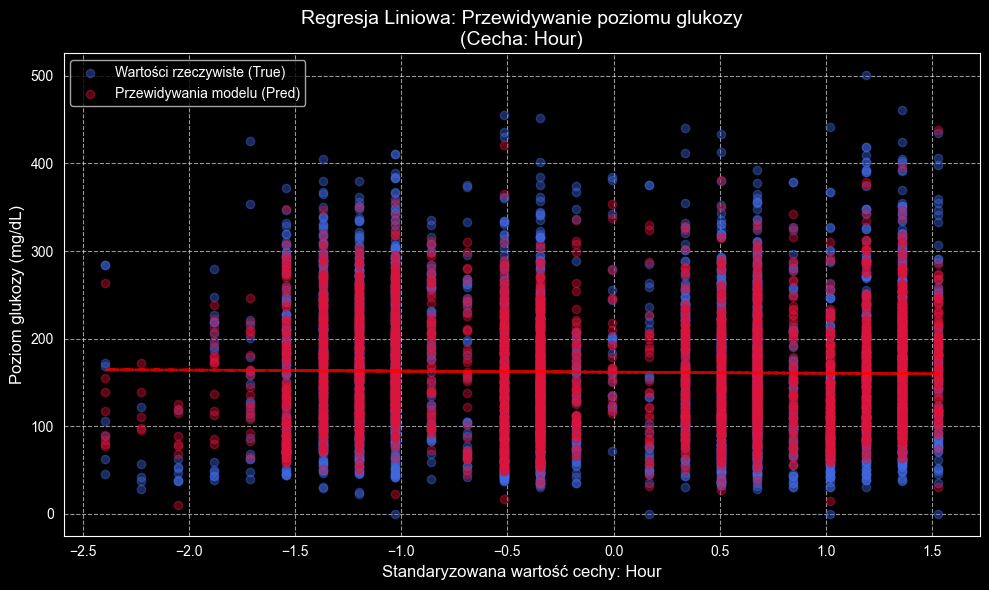

In [108]:
# 1. Obliczamy przewidywania dla modelu regresji liniowej
y_pred_lin = model_reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
feature_name = X.columns[0]

plt.scatter(X_test_scaled[:, 0], y_test, alpha=0.4, color='royalblue', label='Wartości rzeczywiste (True)')
plt.scatter(X_test_scaled[:, 0], y_pred_lin, alpha=0.4, color='crimson', label='Przewidywania modelu (Pred)')
z = np.polyfit(X_test_scaled[:, 0], y_pred_lin, 1)
p = np.poly1d(z)
plt.plot(X_test_scaled[:, 0], p(X_test_scaled[:, 0]), "r--", alpha=0.8, linewidth=2)

plt.title(f'Regresja Liniowa: Przewidywanie poziomu glukozy\n(Cecha: {feature_name})', fontsize=14)
plt.xlabel(f'Standaryzowana wartość cechy: {feature_name}', fontsize=12)
plt.ylabel('Poziom glukozy (mg/dL)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
# Tworzymy nową zmienną celu: 1 jeśli cukier > 180 (wysoki), 0 w przeciwnym razie
y_class = (df_model['Glucose_Level'] > 180).astype(int)

# Sprawdźmy, jak rozkładają się klasy
print(y_class.value_counts())

# 1. Podział danych
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 2. Skalowanie
scaler_svm = StandardScaler()
X_train_scaled_svm = scaler_svm.fit_transform(X_train_svm)
X_test_scaled_svm = scaler_svm.transform(X_test_svm)

# 3. Budowa i trenowanie modelu
# model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
model_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
model_svm.fit(X_train_scaled_svm, y_train_svm)

# 4. Predykcja
y_pred_svm = model_svm.predict(X_test_scaled_svm)

# 5. Ocena
print("\nRaport klasyfikacji:")
print(classification_report(y_test_svm, y_pred_svm))

Glucose_Level
0    11363
1     6956
Name: count, dtype: int64

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2297
           1       0.68      0.82      0.74      1367

    accuracy                           0.79      3664
   macro avg       0.78      0.79      0.78      3664
weighted avg       0.80      0.79      0.79      3664



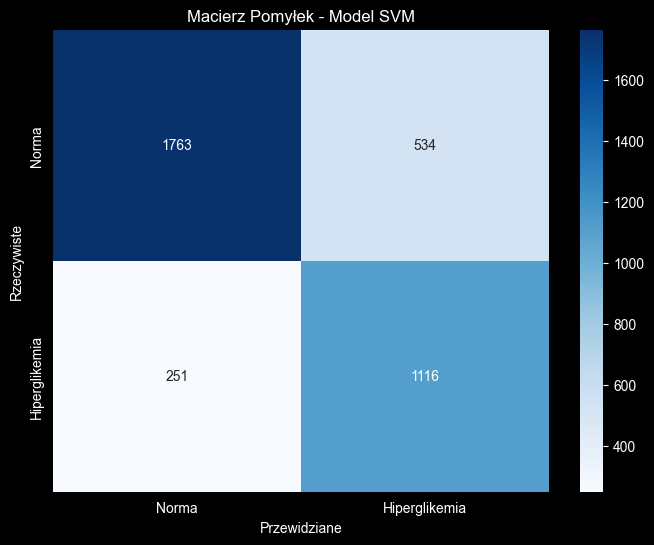

In [110]:
# Generowanie macierzy pomyłek
cm = confusion_matrix(y_test_svm, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Norma', 'Hiperglikemia'],
            yticklabels=['Norma', 'Hiperglikemia'])
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek - Model SVM')
plt.show()